In [1]:
import sys
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb

sys.path.append("C:\\Users\\brady\\Documents\\FootballBetting\\FootballBetting\\processing")

from get_season_stats import GetTeamStats, get_multi_seasons

season_dir='C:\\Users\\brady\\Documents\\FootballBetting\\FootballBetting\\data\\results'
eos_stats_path='C:\\Users\\brady\\Documents\\FootballBetting\\FootballBetting\\data\\eos_stats\\SeasonSummaries.csv'

In [2]:
E1_1718 = GetTeamStats('E1', '1718', season_dir, eos_stats_path, include_odds=True)

In [3]:
test = []
for i in range(3):
    test.append(GetTeamStats('E{}'.format(i), '1718', season_dir, eos_stats_path, include_odds=True).getFixAndStats())


In [4]:
test[0].head()

,Date,HomeTeam,AwayTeam,B365H,B365D,B365A,BWH,BWD,BWA,IWH,...,At_Conceded_A,At_Shots_For_A,At_Shots_Ag_A,At_Shots_Tg_For_A,At_Shots_Tg_Ag_A,At_Fouls_For_A,At_Fouls_Ag_A,At_Bk_Pts_A,At_Promoted,At_Relegated
0,11/08/17,Arsenal,Leicester,1.53,4.50,6.50,1.50,4.60,6.75,1.47,...,38.0,192.0,297.0,62.0,100.0,250.0,164.0,435.0,0,0
1,31/03/18,Brighton,Leicester,2.70,3.20,2.62,2.70,3.10,2.80,2.75,...,38.0,192.0,297.0,62.0,100.0,250.0,164.0,435.0,0,0
2,13/01/18,Chelsea,Leicester,1.30,5.75,12.00,1.26,5.75,11.50,1.33,...,38.0,192.0,297.0,62.0,100.0,250.0,164.0,435.0,0,0
3,28/04/18,Crystal Palace,Leicester,2.04,3.60,3.79,2.05,3.30,3.80,2.00,...,38.0,192.0,297.0,62.0,100.0,250.0,164.0,435.0,0,0
4,31/01/18,Everton,Leicester,3.00,3.20,2.62,2.95,3.10,2.55,2.70,...,38.0,192.0,297.0,62.0,100.0,250.0,164.0,435.0,0,0


# Basic Benchmarking 
- Bet on home
- Measure by accuracy
- Single year test

In [5]:
import pandas as pd

for i in range(3):
    acc = abs(test[i][["HomeWin", "AwayWin", "Draw"]].values 
        - pd.DataFrame([[1] * len(test[i]), [0] * len(test[i]), [0] * len(test[i])]).T.values).mean()
    
    print("league {}: {}".format(i, acc))


    

league 0: 0.3631578947368421
league 1: 0.37922705314009664
league 2: 0.39473684210526316


## Findings
- Better than average
- Seems to matter in lower leagues
    - Possibly a feature

# Model V1
- Initial GBM model
- Use previous season stats to inform prediction

## Prep

In [9]:
from importlib import reload
from get_season_stats import get_multi_seasons

dfs = []
for i in range(3):
    df = get_multi_seasons(1617, 5, season_dir, eos_stats_path, league='E{}'.format(i))
    dfs.append(df)
    
    

In [11]:
data = pd.concat(dfs)

In [13]:
X = data.loc[:,'Ht_Position':]
y = data.loc[:, ['HomeWin', "AwayWin", "Draw"]]

In [20]:
import numpy as np
np.argmax(y.values, axis=1)

array([1, 1, 2, ..., 0, 1, 1], dtype=int64)

In [22]:
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X.values, np.argmax(y.values, axis=1))

LGBMClassifier()

In [25]:
for i in range(3):
    y_test = test[i][["HomeWin", "AwayWin", "Draw"]].values 
    X_test = test[i].loc[:,'Ht_Position':].values
    y_pred = clf.predict_proba(X_test)
    
    acc = abs(y_test - y_pred).mean()
    
    print("league {}: {}".format(i, acc))

league 0: 0.3907025243967549
league 1: 0.4315312866949245
league 2: 0.4402638429966812


In [26]:
y_pred

array([[0.5623484 , 0.22393952, 0.21371208],
       [0.45099232, 0.33019656, 0.21881112],
       [0.43620943, 0.2451007 , 0.31868987],
       ...,
       [0.28910269, 0.15653915, 0.55435816],
       [0.31284163, 0.43678836, 0.25037001],
       [0.61446831, 0.28038688, 0.1051448 ]])

In [27]:
y_test

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=int64)

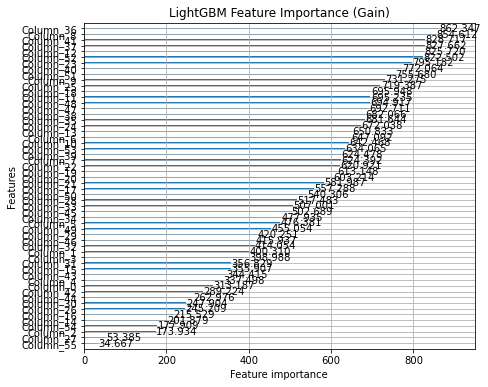

In [34]:
import matplotlib.pyplot as plt
lgb.plot_importance(clf, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()